# Continuity Test

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'data.csv'
repetitionsCount = -1 # -1 = auto-detect
factor = 'N'

tIntervalAlpha = 0.9

plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount', 'Floorplan.coveredUsers:sum', 'Floorplan.collisions:sum', 'Floorplan.msgsPerSlot:sum']
# Filter vectors
vectorsFilter = ['Floorplan.coveredUsers:vector']
# Percentiles
percentiles = [0.25, 0.5, 0.75, 0.9, 0.95]

# Performance indexes
perfIndexes = [
    ('coveredUsersPercent', 'percentage of covered users'),
    ('Floorplan.collisions:sum', 'total number of collisions'),
    ('Floorplan.msgsPerSlot:sum', 'total number of messages sent'),
]
intPercentiles = [int(i*100) for i in percentiles]
vecPerfIndexes = []
for intPercentile in intPercentiles:
    vecPerfIndexes.append(('broadcastTime' + str(intPercentile), 'Broadcast time needed to reach the ' + str(intPercentile) + 'th percentile of the coverage'))
for v in vecPerfIndexes:
    perfIndexes.append(v)

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Repetitions: 20


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([factor, 'repetition'], inplace=True)
scalars_wide = scalars_wide[[factor, 'repetition', *scalarsFilter]]

# coverage
scalars_wide['coveredUsersPercent'] = scalars_wide['Floorplan.coveredUsers:sum'] / (scalars_wide['Floorplan.userCount'] - 1)

## Load vectors

In [6]:
vectors = df[df.type == 'vector']
vectors = vectors.assign(qname = vectors.module + '.' + vectors.name)
for index in scalars_wide.index:
    r = index
    fac = scalars_wide.loc[index, factor]
    rep = scalars_wide.loc[index, 'repetition']
    vectors.loc[vectors.run == r, factor] = fac
    vectors.loc[vectors.run == r, 'repetition'] = rep
vectors = vectors[vectors.qname.isin(vectorsFilter)]
vectors.sort_values([factor, 'repetition', 'qname'], inplace=True)
vectors = vectors[[factor, 'repetition', 'qname', 'vectime', 'vecvalue']]

## Compute scalars from vectors

In [7]:
def get_percentile(percentile, vectime, vecvalue, totalvalue):
    tofind = percentile * totalvalue
    idx = 0
    csum = vecvalue.cumsum()
    for value in csum:
        if value >= tofind:
            return vectime[idx]
        idx += 1
    return math.inf

for index, row in vectors.iterrows():
    for vecPerf, percentile in zip(vecPerfIndexes, percentiles):
        vecPerfIndex = vecPerf[0]
        fac = row[factor]
        rep = row['repetition']
        if vecPerfIndex.startswith('broadcastTime'):
            total = scalars_wide[(scalars_wide[factor] == fac) & (scalars_wide['repetition'] == rep)]['Floorplan.userCount'].values[0] - 1
        else:
            raise Exception('Need to specify total for ' + vecPerfIndex + '. (coding required)')
        value = get_percentile(percentile, row['vectime'], row['vecvalue'], total)
        scalars_wide.loc[(scalars_wide[factor] == fac) & (scalars_wide['repetition'] == rep), vecPerfIndex] = value
    
factorValues = scalars_wide[factor].unique()

## Plot

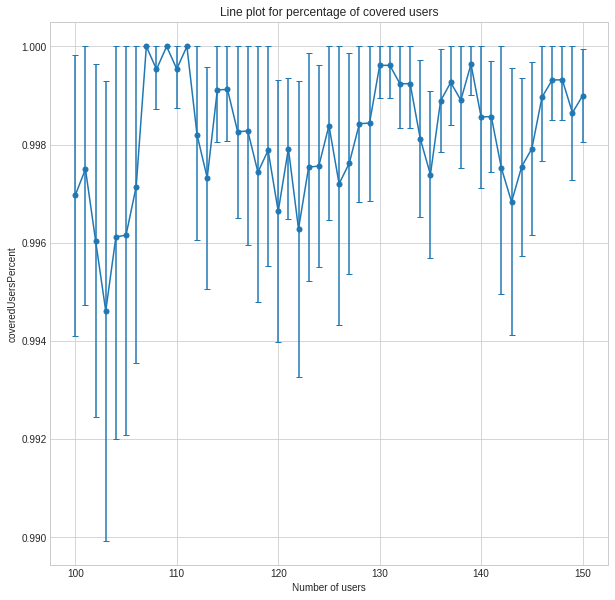

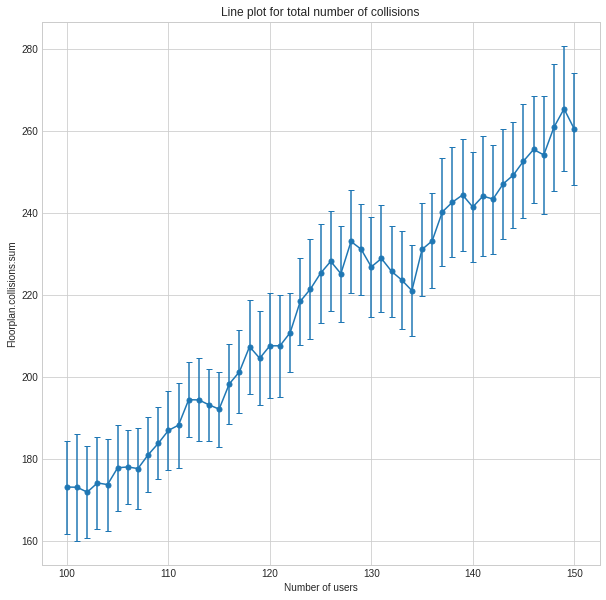

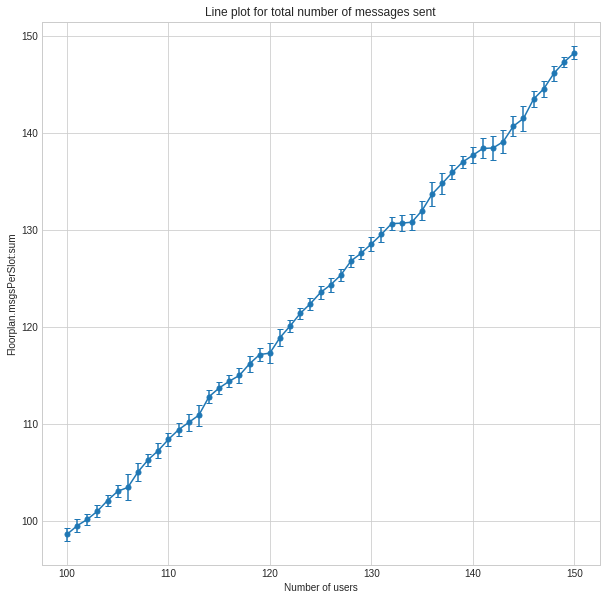

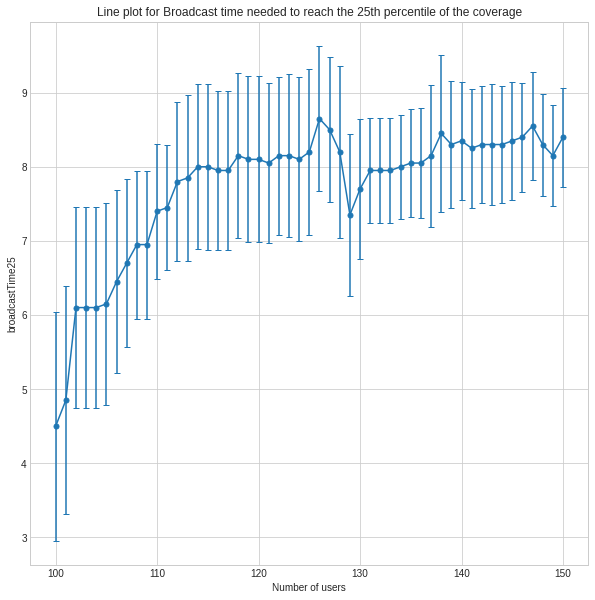

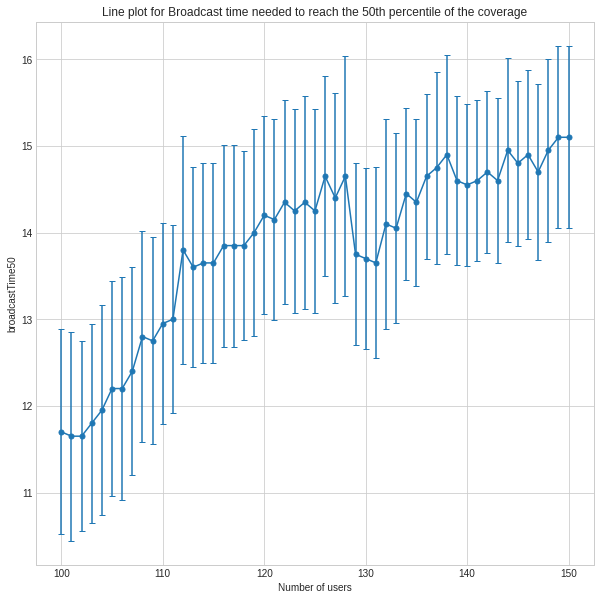

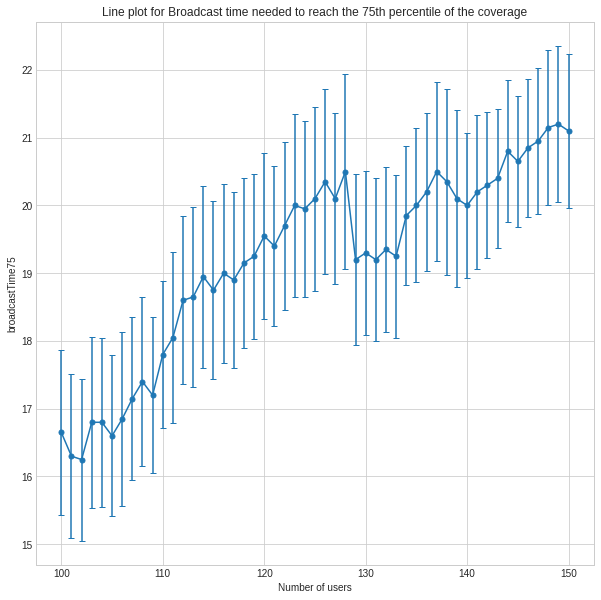

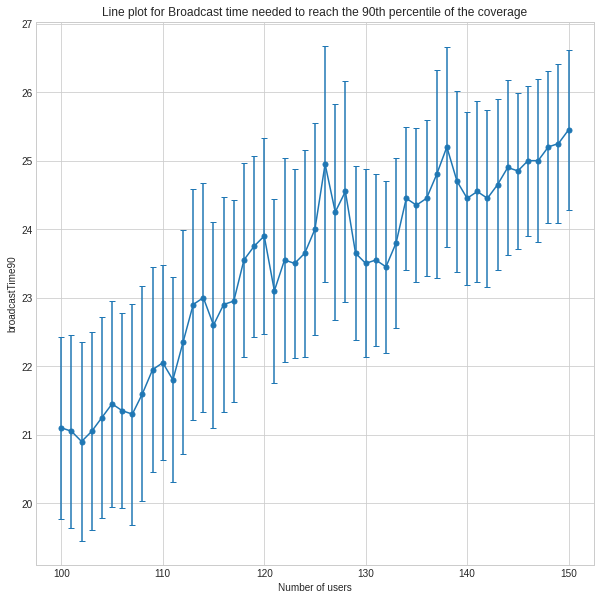

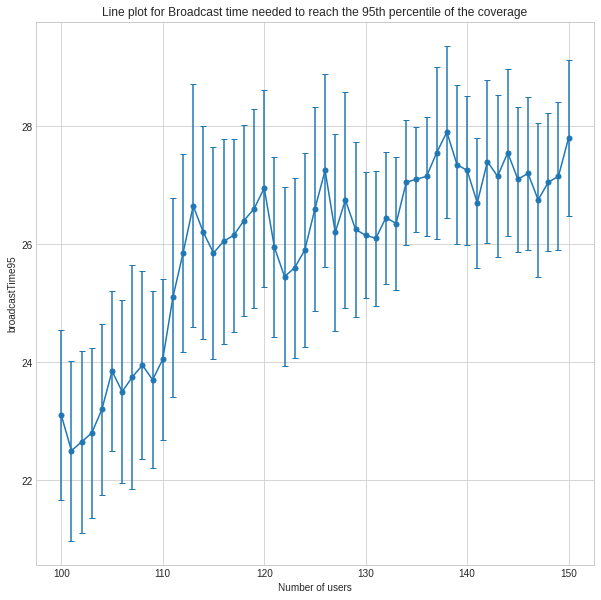

In [8]:
for perfIndex, perfIndexDesc in perfIndexes:
    x = []
    y = []
    err = []
    poserr = []
    for value in factorValues:
        x.append(value)
        obssum = 0
        mean = scalars_wide[scalars_wide[factor] == value][perfIndex].mean()
        variance = scalars_wide[scalars_wide[factor] == value][perfIndex].var()
        _, positiveInterval = tuple(v*math.sqrt(variance/repetitionsCount) for v in stats.t.interval(tIntervalAlpha, repetitionsCount - 1))
        y.append(mean)
        if perfIndex == 'coveredUsersPercent':
            poserr.append(min(1 - mean, positiveInterval))
        err.append(positiveInterval)
    if len(poserr) > 0:
        err = [err, poserr]
    plt.figure(figsize=plotSize)
    plt.style.use(plotStyle)
    plt.errorbar(x=np.array(x), y=np.array(y), yerr=np.array(err), capsize=3, linestyle='-', marker='.', markersize=10)
    plt.title('Line plot for ' + perfIndexDesc)
    plt.ylabel(perfIndex)
    plt.xlabel('Number of users')
    if saveFigures:
        fig = plt.gcf()
        fig.savefig('figures/' + get_file_name(perfIndex) + '-lineplot.png')
    plt.show()

For the percentage of covered users, the observations do not vary too much between different executions (from ~99% to 100% with a 90% confidence interval).

For all the other indexes, the observations just vary a little when the number of users is slightly increased. Moreover, we can see that all the indexes have a raising trend with the number of users as expected.

Variance is high for the broadcast time but this does not ruins the visualization of the trend.

Test passed.

### Rerun this notebook

To rerun this notebook, you can:
- just rerun the simulations with the corresponding configuration: `./simulate.sh -s ContinuityTest -c Continuity`
- download our datasets from `https://drive.google.com/file/d/1ZFRV2DecoTvax9lngEsuPPw8Cz1DXvLc/view?usp=sharing` (login with UNIPI institutional account)